In [19]:
import gym
import cv2

#This environment wrapper is used to stop a run if mario is stuck on a pipe
class DeadlockEnv(gym.Wrapper):
    def __init__(self, env, threshold=20):
        super().__init__(env)
        self.last_x_pos = 0
        self.count = 0
        self.threshold = threshold
        self.lifes = 3
        self.stage = 1
        self.world = 1

    def reset(self, **kwargs):
        self.last_x_pos = 0
        self.count = 0
        return self.env.reset(**kwargs)

    def step(self, action):
        state, reward, done, info = self.env.step(action)
        x_pos = info['x_pos']

        if x_pos <= self.last_x_pos:
            self.count += 1
        else:
            self.count = 0
            self.last_x_pos = x_pos

        if info['life'] != self.lifes or info["stage"] != self.stage or info["world"] != self.world:
            self.last_x_pos = x_pos
            self.count = 0
            self.lifes = info['life']
            self.stage = info["stage"]
            self.world = info["world"]

        if self.count >= self.threshold:
            reward = -15
            done = True

        return state, reward, done, info

#skipframe wrapper
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        reward_out = 0
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            reward_out += reward
            if done:
                break
        reward_out /= max(1,i+1)

        return obs, reward_out, done, info

#downsample wrapper to reduce dimensionality
def Downsample(ratio,state):
  (oldh, oldw, oldc) = state.shape
  newshape = (oldh//ratio, oldw//ratio, oldc)
  frame = cv2.resize(state, (newshape[0], newshape[1]), interpolation=cv2.INTER_AREA)
  return frame

#small function to change rgb images to grayscale
def GrayScale(state):
  return cv2.cvtColor(state, cv2.COLOR_RGB2GRAY)

def make_env():
    env = gym_super_mario_bros.make('SuperMarioBros-v1')
    env = JoypadSpace(env, SIMPLE_MOVEMENT)
    env = SkipFrame(env, skip=4)
    env = DeadlockEnv(env, threshold=(60*2)//4)
    return env


In [20]:
def save_frames_as_video(frames, output_path, fps=30):
    if not frames:
        print("No frames to save!")
        return

    try:
        import cv2


        height, width, layers = frames[0].shape
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec


        video_writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

        print(f"Saving {len(frames)} frames to {output_path}...")


        for i, frame in enumerate(frames):
            video_writer.write(frame)


            if (i + 1) % 100 == 0:
                print(f"Processed {i + 1}/{len(frames)} frames")

        video_writer.release()
        print(f"Video saved successfully: {output_path}")

    except Exception as e:
        print(f"Error saving video: {e}")


        import os
        frame_dir = output_path.replace('.mp4', '_frames')
        os.makedirs(frame_dir, exist_ok=True)

        print(f"Saving frames as images in {frame_dir}/")
        for i, frame in enumerate(frames):
            cv2.imwrite(f"{frame_dir}/frame_{i:06d}.png", frame)

        print(f"Frames saved as images. You can create video with:")
        print(f"ffmpeg -r {fps} -i {frame_dir}/frame_%06d.png -c:v libx264 -pix_fmt yuv420p {output_path}")

In [21]:
import numpy as np
import torch.nn as nn
from torch.distributions import Categorical

class Actor_Critic:
    def __init__(self, env):
        self.env = env

        self.actor = nn.Sequential(
                            nn.Linear(3840, 64),
                            nn.Tanh(),
                            nn.Linear(64, 64),
                            nn.Tanh(),
                            nn.Linear(64, 7),
                            nn.Softmax(dim=-1)
                        )
        self.critic = nn.Sequential(
                        nn.Linear(3840, 64),
                        nn.Tanh(),
                        nn.Linear(64, 64),
                        nn.Tanh(),
                        nn.Linear(64, 1)
                    )

    def act(self, state):
        # if we have a continuous action space we sample from a multivariate normal distribution
        # otherwise we calculate a categorical action space
        action_probs = self.actor(state)
        dist = Categorical(action_probs)

        action = dist.sample()
        action_logprob = dist.log_prob(action)

        return action.detach(), action_logprob.detach()

    def evaluate(self, state, action):
        action_probs = self.actor(state)
        dist = Categorical(action_probs)
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_values = self.critic(state)

        return action_logprobs, state_values, dist_entropy


In [22]:
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
import numpy as np
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
import torch.optim as optim
import collections
import keyboard
import cv2
import torch

frameskip = 4

env = gym_super_mario_bros.make('SuperMarioBros-v1')
env = JoypadSpace(env, SIMPLE_MOVEMENT)
env = SkipFrame(env, skip=frameskip)
env = DeadlockEnv(env,threshold=(60*2)//frameskip)

done = True

model = Actor_Critic(env)
actor_optimizer = optim.Adam(model.actor.parameters(), lr=1e-3)
critic_optimizer = optim.Adam(model.critic.parameters(), lr=1e-3)
gamma = 0.99
n_steps = 50
state = env.reset()
step = 0
loss_values=[]
xpos_values = []
frames = []
rewards_plt = []
max_reward = 0
reward_count = 0
max_frames = []

states, actions, rewards, logprobs = [], [], [], []

for step in range(300000):
    if done:
        state = env.reset()
    #print(state.shape)

    processed_state = GrayScale(Downsample(4, state)).flatten()
    processed_tensor = torch.from_numpy(processed_state).float()

    action, logprob = model.act(processed_tensor)
    next_state, reward, done, info = env.step(action.item())


    next_helper = next_state.copy()
    frame_bgr = cv2.cvtColor(state, cv2.COLOR_RGB2BGR)
    frames.append(frame_bgr)

    states.append(processed_tensor.unsqueeze(0))
    actions.append(action)
    logprobs.append(logprob)
    rewards.append(torch.tensor([reward], dtype=torch.float32))
    reward_count += reward
    state = next_helper
    step += 1

    if step % n_steps == 0 or done:
        with torch.no_grad():
            next_processed = GrayScale(Downsample(4, state)).flatten()
            next_tensor = torch.from_numpy(next_processed).float()
            next_value = model.critic(next_tensor) if not done else torch.tensor([[0.0]])

        returns = []
        R = next_value
        for r in reversed(rewards):
            R = r + gamma * R
            returns.insert(0, R)










        states_tensor = torch.cat(states)
        actions_tensor = torch.stack(actions)
        logprobs_tensor = torch.stack(logprobs)
        returns_tensor = torch.cat(returns).detach()
        #returns_tensor = (returns_tensor - returns_tensor.mean()) / (returns_tensor.std() + 1e-8)
        if returns_tensor.numel() >1:
            returns_tensor = (returns_tensor - returns_tensor.mean()) / (returns_tensor.std() + 1e-8)        #    adv_std = advantage.std()
        #        advantage = advantage - advantage.mean()  # Nur zentrieren
        #    else:
        #        advantage = (advantage - advantage.mean()) / (adv_std + 1e-8)
        #else :
        #    advantage = advantage - advantage.mean()


        new_logprobs, values, entropy = model.evaluate(states_tensor, actions_tensor)
        advantage = returns_tensor - values.squeeze()
        if advantage.numel() > 1:
            adv_std = advantage.std()
            if adv_std < 1e-6:
                advantage = advantage - advantage.mean()
            else:
                advantage = (advantage - advantage.mean()) / (adv_std + 1e-8)
        else :
            advantage = advantage - advantage.mean()


        policy_loss = -(new_logprobs * advantage.detach()).mean()
        value_loss = advantage.pow(2).mean()
        entropy_bonus = entropy.mean()
        total_loss = policy_loss + 0.5 * value_loss - 0.01 * entropy_bonus


        if torch.isnan(total_loss):
            print(returns_tensor)
            print(values)
            print(returns_tensor-values)
            print("NaN detected!")
            print("Returns:", returns_tensor)
            print("Values:", values)
            print("Advantage:", advantage)
            break  # oder: continue / reset

        actor_optimizer.zero_grad()
        critic_optimizer.zero_grad()
        total_loss.backward()
        actor_optimizer.step()
        critic_optimizer.step()

        states, actions, rewards, logprobs = [], [], [], []
        loss_values.append(total_loss.item())
        """
        print("Policy loss:", policy_loss.item())
        print("Value loss:", value_loss.item())
        print("Entropy bonus:", entropy_bonus.item())
        print("Mean advantage:", advantage.mean().item())
        print("Mean return:", returns_tensor.mean().item())
        print('_____________________________')
        """
    if step % 1000 == 0:
        print(f"step: {step}")

    if done:
        rewards_plt.append(reward_count)
        if reward_count > max_reward:
            max_frames = frames
            max_reward = reward_count
        xpos_values.append(info['x_pos'])
        reward_count = 0
        frames = []
        #print(np.shape(GrayScale(Downsample(4,state))))
        #print(f" Loss:{total_loss} Xpos:{info['x_pos']}")
        #print('_____________________________')
    if step > 450000:
        env.render()
save_frames_as_video(max_frames, "A&C_mario_gameplay.mp4", fps=30)
env.close()


step: 1000
step: 2000
step: 3000
step: 4000
step: 5000
step: 6000
step: 7000
step: 8000
step: 9000
step: 10000
step: 11000
step: 12000
step: 13000
step: 14000
step: 15000
step: 16000
step: 17000
step: 18000
step: 19000
step: 20000
step: 21000
step: 22000
step: 23000
step: 24000
step: 25000
step: 26000
step: 27000
step: 28000
step: 29000
step: 30000
step: 31000
step: 32000
step: 33000
step: 34000
step: 35000
step: 36000
step: 37000
step: 38000
step: 39000
step: 40000
step: 41000
step: 42000
step: 43000
step: 44000
step: 45000
step: 46000
step: 47000
step: 48000
step: 49000
step: 50000
step: 51000
step: 52000
step: 53000
step: 54000
step: 55000
step: 56000
step: 57000
step: 58000
step: 59000
step: 60000
step: 61000
step: 62000
step: 63000
step: 64000
step: 65000
step: 66000
step: 67000
step: 68000
step: 69000
step: 70000
step: 71000
step: 72000
step: 73000
step: 74000
step: 75000
step: 76000
step: 77000
step: 78000
step: 79000
step: 80000
step: 81000
step: 82000
step: 83000
step: 84000
s

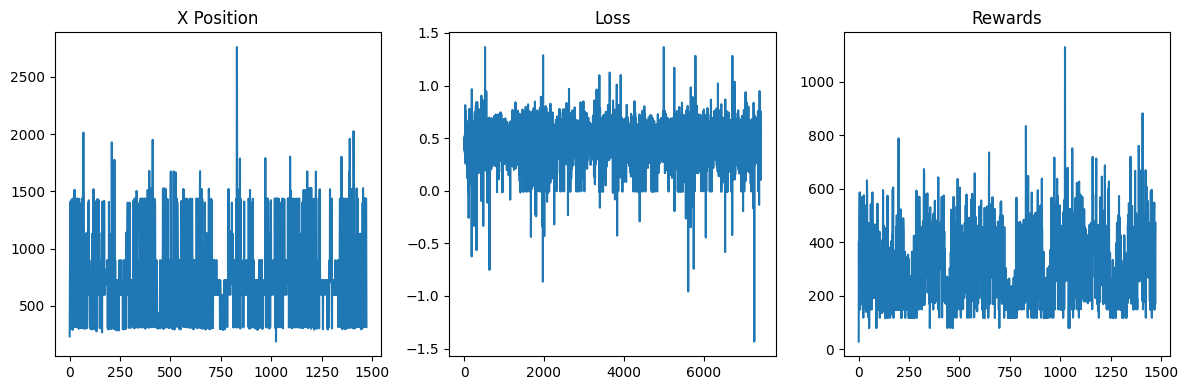

In [26]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # 1 row, 3 columns

# Plot on each subplot
axes[0].plot(xpos_values)
axes[0].set_title("X Position")

axes[1].plot(loss_values)
axes[1].set_title("Loss")

axes[2].plot(rewards_plt)
axes[2].set_title("Rewards")

# Optional: layout adjustment
plt.tight_layout()
plt.show()

fig.savefig('A_C_exploding loss A:e-3,C:e-3_norm_300k.png')